# Análise Exploratória — Delivery Delay & Customer Satisfaction

> **POC:** DelayImpact Analytics  
> **Objetivo:** Analisar o impacto do atraso logístico na satisfação do cliente  

Este notebook documenta a etapa de **Análise Exploratória Guiada (EDA)** da POC B, utilizando como base a camada Gold previamente construída no notebook [`02_gold_delivery_analytics.ipynb`](02_gold_delivery_analytics.ipynb).

O foco desta análise é investigar, de forma estruturada, **como atrasos na entrega afetam a percepção do cliente**, medida por avaliações (reviews), comentários e padrões de comportamento associados.

---

## Contexto Analítico

A experiência de entrega é um dos principais fatores de satisfação em operações de e-commerce. Pequenos atrasos podem gerar frustração significativa, enquanto atrasos recorrentes ou prolongados tendem a impactar diretamente indicadores de reputação, recompra e confiança do consumidor.

Com a camada Gold `gold_delay_satisfaction`, temos uma base consolidada em nível de pedido que conecta:
- Métricas de atraso e desempenho logístico
- Dados financeiros e de volume
- Avaliações e comportamento do cliente

Esta EDA não tem caráter exploratório livre.  
Trata-se de uma **análise guiada por hipóteses**, orientada à geração de insights acionáveis.

---

## Objetivo da EDA

Os objetivos desta análise são:

- Quantificar o impacto do atraso na nota de avaliação do cliente
- Avaliar como diferentes níveis de atraso afetam detratores e promotores
- Identificar padrões por categoria de produto e região
- Avaliar o papel da presença de comentários textuais como sinal de insatisfação
- Apoiar diagnósticos operacionais e priorização de melhorias logísticas

Ao final desta etapa, espera-se obter **insumos claros para tomada de decisão**, não apenas descrições estatísticas.

# Conexão e Verificação Inicial

Nesta seção são realizadas a importação das bibliotecas necessárias, a conexão com o banco de dados DuckDB e uma verificação inicial das tabelas e views disponíveis no ambiente analítico.

In [1]:
import sys; sys.path.insert(0, "..")
import duckdb
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from src.paths import PROCESSED_DATA

sns.set(style="whitegrid")

In [2]:
con = duckdb.connect(database=str(PROCESSED_DATA), read_only=False)
con.execute("SELECT 1").fetchone()

(1,)

In [3]:
df = con.execute("""
SELECT *
FROM gold_delay_satisfaction
""").df()

con.close()

# 1. Análise Inicial e Sanidade dos Dados

In [4]:
# Dimensão do Dataset
df.shape

(99441, 38)

In [5]:
# Estrutura e Tipos de Dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 99441 non-null  object        
 1   customer_id              99441 non-null  object        
 2   order_status             99441 non-null  object        
 3   is_completed_order       99441 non-null  int32         
 4   has_review               99441 non-null  int32         
 5   purchase_date            99441 non-null  datetime64[us]
 6   delivered_date           96476 non-null  datetime64[us]
 7   estimated_delivery_date  99441 non-null  datetime64[us]
 8   purchase_year            99441 non-null  int64         
 9   purchase_month           99441 non-null  int64         
 10  days_to_deliver          96476 non-null  Int64         
 11  delay_days               96476 non-null  Int64         
 12  delay_days_pos           99441 n

In [6]:
# Checagem de Unicidade do Pedido
df['order_id'].nunique(), df.shape[0]

(99441, 99441)

In [7]:
# Nulos nas Colunas-Chave
cols_relevant = [
    'delay_days',
    'review_score',
    'delay_bucket',
    'is_delayed',
    'satisfaction_group'
]

df[cols_relevant].isna().sum()

delay_days            2965
review_score           768
delay_bucket             0
is_delayed               0
satisfaction_group       0
dtype: int64

In [8]:
# Estatísticas Descritivas Básicas
df['delay_days'].describe()

count      96476.0
mean    -11.876881
std      10.183854
min         -147.0
25%          -17.0
50%          -12.0
75%           -7.0
max          188.0
Name: delay_days, dtype: Float64

In [9]:
#Score de Avaliação
df['review_score'].describe()

count     98673.0
mean     4.086437
std      1.347573
min           1.0
25%           4.0
50%           5.0
75%           5.0
max           5.0
Name: review_score, dtype: Float64

In [10]:
# Distribuição dos Buckets (sanidade)
df['delay_bucket'].value_counts().sort_index()

delay_bucket
delay_15_plus     1384
delay_1_3         1870
delay_4_7         1802
delay_8_14        1478
not_delivered     2971
on_time          89936
Name: count, dtype: int64

## Resumo Análises Iniciais

> Nesta etapa, foi realizada uma análise inicial de sanidade e estrutura dos dados, com o objetivo de validar a consistência das variáveis centrais para a análise de atraso e satisfação.
>
> Apesar da presença de valores nulos pontuais e de outliers esperados em dados logísticos reais, a base mostrou-se adequada para uma análise diagnóstica orientada a negócio.
>
> A partir dessa validação, o escopo analítico foi deliberadamente restrito a um subconjunto de variáveis diretamente relacionadas à pergunta de negócio, garantindo foco, clareza e interpretabilidade dos resultados.

# 2. EDA (Atraso x Satisfação do Cliente)

Nesta seção, a análise avança da caracterização do atraso para a avaliação de seu impacto direto na experiência do cliente.  
Mais do que identificar a presença de atrasos, o objetivo é compreender **como a intensidade do atraso influencia a percepção do serviço**, medida por meio das avaliações dos clientes.

A partir da segmentação dos pedidos em buckets de atraso, a análise investiga a relação entre tempo de entrega e satisfação, buscando identificar padrões, pontos de inflexão e níveis de atraso associados a quedas mais acentuadas na avaliação do e-commerce.

## 2.1. Distribuição do atraso

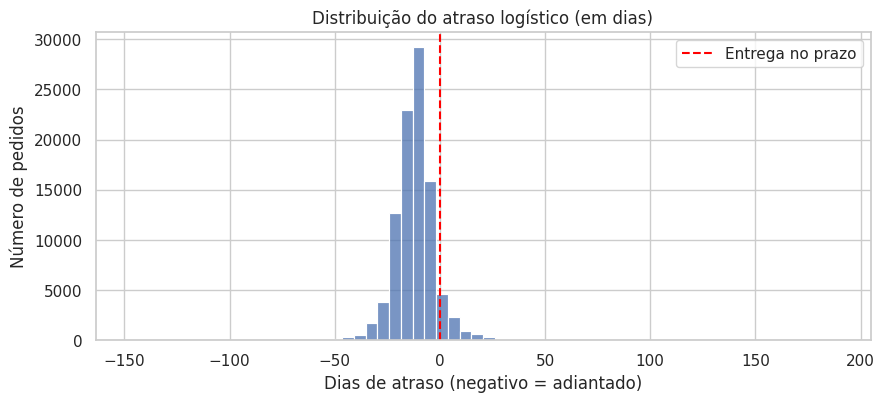

In [11]:
# Distribuição geral do atraso (delay_days)
plt.figure(figsize=(10, 4))
sns.histplot(df['delay_days'], bins=60, kde=False)
plt.axvline(0, color='red', linestyle='--', label='Entrega no prazo')
plt.title('Distribuição do atraso logístico (em dias)')
plt.xlabel('Dias de atraso (negativo = adiantado)')
plt.ylabel('Número de pedidos')
plt.legend()
plt.show()

In [12]:
# Foco apenas em pedidos atrasados
df_delayed = df[df['delay_days'] > 0]

df_delayed['delay_days'].describe()

count       6535.0
mean     10.620352
std      14.643844
min            1.0
25%            3.0
50%            7.0
75%           13.0
max          188.0
Name: delay_days, dtype: Float64

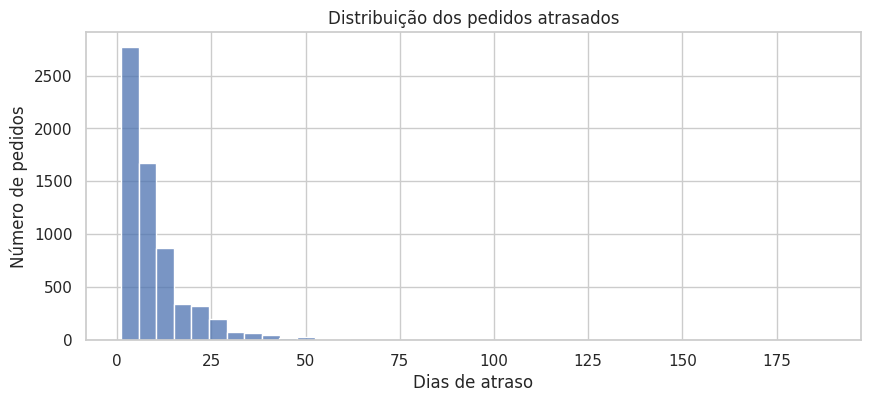

In [13]:
# Histograma apenas dos atrasos

plt.figure(figsize=(10, 4))
sns.histplot(df_delayed['delay_days'], bins=40, kde=False)
plt.title('Distribuição dos pedidos atrasados')
plt.xlabel('Dias de atraso')
plt.ylabel('Número de pedidos')
plt.show()

In [14]:
# Distribuição por bucket de atraso
bucket_counts = (
    df['delay_bucket']
    .value_counts()
    .reindex([
        'on_time',
        'delay_1_3',
        'delay_4_7',
        'delay_8_14',
        'delay_15_plus',
        'not_delivered'
    ])
)

bucket_counts


delay_bucket
on_time          89936
delay_1_3         1870
delay_4_7         1802
delay_8_14        1478
delay_15_plus     1384
not_delivered     2971
Name: count, dtype: int64

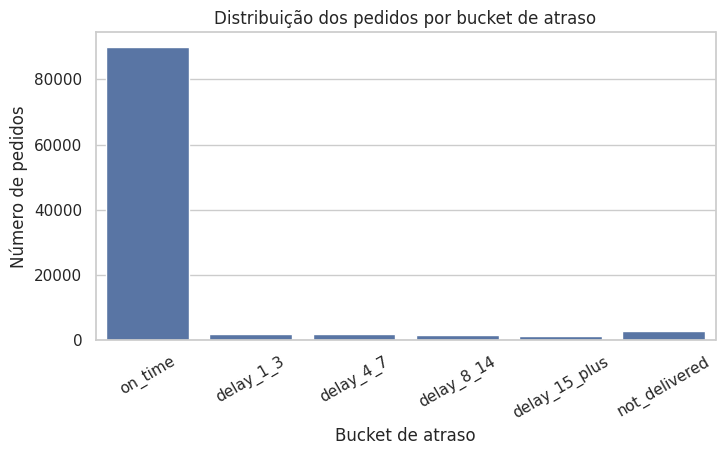

In [15]:
# Visualização dos buckets
plt.figure(figsize=(8, 4))
sns.barplot(
    x=bucket_counts.index,
    y=bucket_counts.values
)
plt.title('Distribuição dos pedidos por bucket de atraso')
plt.xlabel('Bucket de atraso')
plt.ylabel('Número de pedidos')
plt.xticks(rotation=30)
plt.show()

### Resumo - Distribuição do atraso

> A distribuição dos atrasos indica que a maioria dos pedidos é entregue no prazo, enquanto os pedidos atrasados representam uma fração menor do volume total.
>
> No entanto, os atrasos apresentam intensidade variável, com uma mediana de 7 dias e uma cauda longa que inclui atrasos significativos.
>
> Essa heterogeneidade justifica a segmentação por buckets de atraso, permitindo avaliar não apenas a presença do atraso, mas também sua intensidade nos impactos analisados a seguir.

## 2.2. Atraso logístico x satisfação do cliente

In [16]:
# Score médio por bucket de atraso
score_by_bucket = (
    df
    .groupby('delay_bucket')['review_score']
    .mean()
    .reindex([
        'on_time',
        'delay_1_3',
        'delay_4_7',
        'delay_8_14',
        'delay_15_plus',
        'not_delivered'
    ])
)

score_by_bucket

delay_bucket
on_time          4.290464
delay_1_3        3.291037
delay_4_7        2.104691
delay_8_14       1.670816
delay_15_plus    1.722846
not_delivered    1.747631
Name: review_score, dtype: Float64

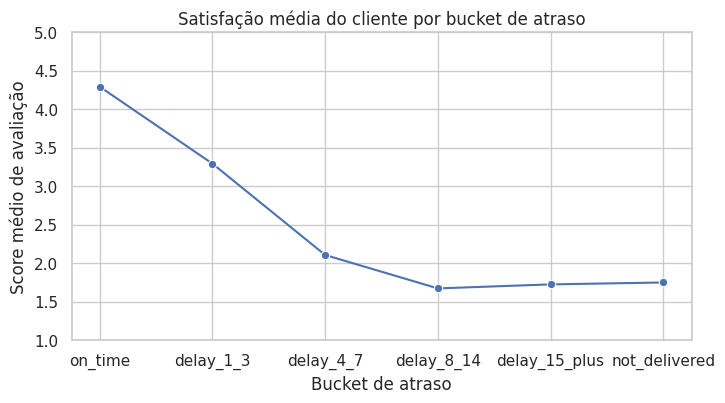

In [17]:
# Score médio × Atraso
plt.figure(figsize=(8, 4))
sns.lineplot(
    x=score_by_bucket.index,
    y=score_by_bucket.values,
    marker='o'
)

plt.title('Satisfação média do cliente por bucket de atraso')
plt.xlabel('Bucket de atraso')
plt.ylabel('Score médio de avaliação')
plt.ylim(1, 5)
plt.grid(True)
plt.savefig(
    "../imagens/score_vs_delay_bucket.png",
    dpi=150,
    bbox_inches="tight"
)

plt.show()

In [18]:
# Diferença relativa em relação a pedidos no prazo
baseline = score_by_bucket.loc['on_time']

score_diff = score_by_bucket - baseline
score_diff

delay_bucket
on_time               0.0
delay_1_3       -0.999428
delay_4_7       -2.185773
delay_8_14      -2.619648
delay_15_plus   -2.567618
not_delivered   -2.542834
Name: review_score, dtype: Float64

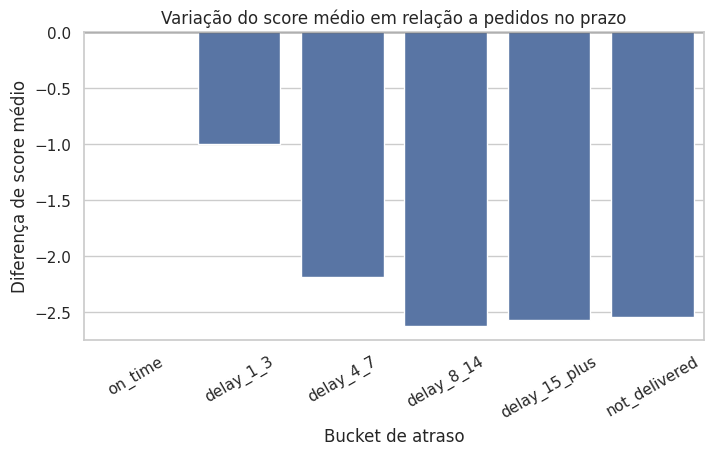

In [19]:
# Visualização da diferença de score
plt.figure(figsize=(8, 4))
sns.barplot(
    x=score_diff.index,
    y=score_diff.values
)

plt.axhline(0, color='black', linewidth=1)
plt.title('Variação do score médio em relação a pedidos no prazo')
plt.xlabel('Bucket de atraso')
plt.ylabel('Diferença de score médio')
plt.xticks(rotation=30)
plt.show()

### Resumo - Atraso logístico x satisfação do cliente

> A análise evidencia uma relação consistente entre atraso na entrega e queda na avaliação do cliente.  
>
>  Pedidos entregues no prazo apresentam níveis elevados de satisfação, enquanto atrasos curtos já produzem impactos relevantes no score médio.
>
> A partir de atrasos de maior intensidade, observa-se um patamar baixo e relativamente estável de satisfação, indicando que o efeito negativo ocorre de forma precoce.  
>
> Esse comportamento justifica o uso de buckets de atraso e sustenta a análise diagnóstica apresentada nos blocos seguintes.

## 2.3. Atraso logístico x Detratores

In [20]:
# Definição de detrator
df['satisfaction_group'].value_counts(normalize=True)

satisfaction_group
promoter     0.764785
detractor    0.145725
passive      0.081767
no_review    0.007723
Name: proportion, dtype: float64

In [21]:
#Proporção de detratores por bucket de atraso
detractor_rate = (
    df
    .assign(is_detractor = df['satisfaction_group'] == 'detractor')
    .groupby('delay_bucket')['is_detractor']
    .mean()
    .reindex([
        'on_time',
        'delay_1_3',
        'delay_4_7',
        'delay_8_14',
        'delay_15_plus',
        'not_delivered'
    ])
)

detractor_rate

delay_bucket
on_time          0.092132
delay_1_3        0.318182
delay_4_7        0.655938
delay_8_14       0.784168
delay_15_plus    0.755780
not_delivered    0.748233
Name: is_detractor, dtype: float64

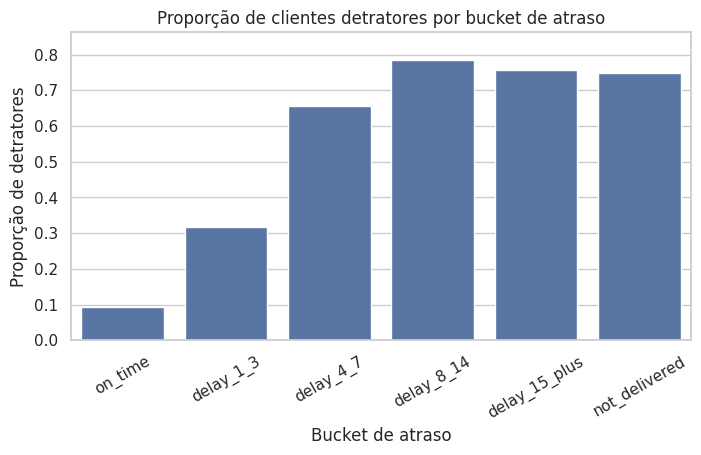

In [22]:
# Visualização da taxa de detratores
plt.figure(figsize=(8, 4))
sns.barplot(
    x=detractor_rate.index,
    y=detractor_rate.values
)

plt.title('Proporção de clientes detratores por bucket de atraso')
plt.xlabel('Bucket de atraso')
plt.ylabel('Proporção de detratores')
plt.ylim(0, detractor_rate.max() * 1.1)
plt.xticks(rotation=30)

plt.savefig(
    "../imagens/detractors_vs_delay_bucket.png",
    dpi=150,
    bbox_inches="tight"
)
plt.show()

In [23]:
# Comparação relativa com pedidos no prazo
baseline_detractor = detractor_rate.loc['on_time']

detractor_diff = detractor_rate - baseline_detractor
detractor_diff

delay_bucket
on_time          0.000000
delay_1_3        0.226050
delay_4_7        0.563806
delay_8_14       0.692036
delay_15_plus    0.663648
not_delivered    0.656101
Name: is_detractor, dtype: float64

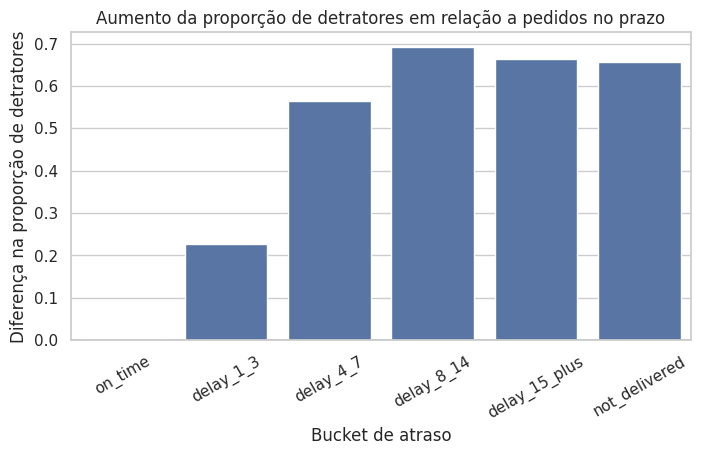

In [24]:
#Visualização da variação relativa
plt.figure(figsize=(8, 4))
sns.barplot(
    x=detractor_diff.index,
    y=detractor_diff.values
)

plt.axhline(0, color='black', linewidth=1)
plt.title('Aumento da proporção de detratores em relação a pedidos no prazo')
plt.xlabel('Bucket de atraso')
plt.ylabel('Diferença na proporção de detratores')
plt.xticks(rotation=30)
plt.show()

### Resumo — Atraso e detratores

> A análise da proporção de detratores por bucket de atraso indica que o atraso logístico está fortemente associado à insatisfação explícita do cliente.  
>
>Pedidos entregues no prazo apresentam baixo risco, enquanto atrasos de maior intensidade elevam substancialmente a probabilidade de avaliações negativas.

## 2.4. Diferenças regionais no impacto do atraso

In [25]:
# Volume de pedidos por UF
orders_by_uf = df['customer_state'].value_counts()

orders_by_uf.head(10)

customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
Name: count, dtype: int64

In [26]:
#Foco em UFs com volume relevante
ufs_relevant = orders_by_uf[orders_by_uf >= 1000].index.tolist()

df_uf = df[df['customer_state'].isin(ufs_relevant)]

In [27]:
# Taxa de detratores por UF (pedidos atrasados)
df_delayed = df_uf[df_uf['is_delayed'] == 1]

detractor_by_uf = (
    df_delayed
    .assign(is_detractor = df_delayed['satisfaction_group'] == 'detractor')
    .groupby('customer_state')['is_detractor']
    .mean()
    .sort_values(ascending=False)
)

detractor_by_uf

customer_state
DF    0.720339
RJ    0.711706
PE    0.686275
CE    0.676136
RS    0.633846
GO    0.617188
SC    0.584192
BA    0.583333
MG    0.573077
ES    0.537383
SP    0.532967
PR    0.507538
Name: is_detractor, dtype: float64

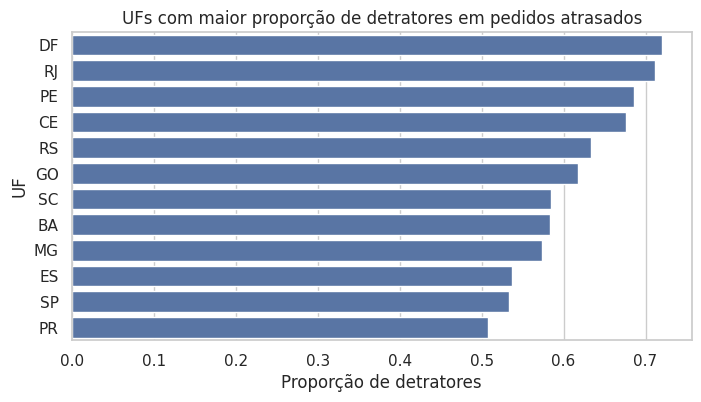

In [28]:
# Visualização das UFs mais sensíveis
plt.figure(figsize=(8, 4))
sns.barplot(
    x=detractor_by_uf.values,
    y=detractor_by_uf.index
)

plt.title('UFs com maior proporção de detratores em pedidos atrasados')
plt.xlabel('Proporção de detratores')
plt.ylabel('UF')

plt.savefig(
    "../imagens/detractors_by_state.png",
    dpi=150,
    bbox_inches="tight"
)
plt.show()

In [29]:
baseline_detractor_delayed = (
    df[df['is_delayed'] == 1]['satisfaction_group']
    .eq('detractor')
    .mean()
)

baseline_detractor_delayed

np.float64(0.6093343534812548)

In [30]:
detractor_diff_uf = detractor_by_uf - baseline_detractor_delayed
detractor_diff_uf

customer_state
DF    0.111005
RJ    0.102371
PE    0.076940
CE    0.066802
RS    0.024512
GO    0.007853
SC   -0.025142
BA   -0.026001
MG   -0.036257
ES   -0.071951
SP   -0.076367
PR   -0.101797
Name: is_detractor, dtype: float64

### Resumo - Impacto regional do atraso

> A segmentação por estado revela que o impacto do atraso na satisfação do cliente varia significativamente entre regiões.  
>
> Essas diferenças indicam que a experiência de entrega não é percebida de forma homogênea, reforçando a importância de análises segmentadas na priorização de ações.

# 3. Síntese Analítica Geral

A análise exploratória guiada evidencia que, embora a maior parte dos pedidos seja entregue no prazo, o atraso logístico exerce impacto significativo e precoce na satisfação do cliente.

A partir da segmentação dos pedidos por intensidade de atraso, observou-se que quedas relevantes no score médio ocorrem mesmo em atrasos curtos, com deterioração acentuada da experiência já nos primeiros dias. Esse efeito se mantém estável em atrasos mais longos, indicando que o dano à percepção do serviço acontece de forma antecipada.

Além da redução do score médio, o atraso está fortemente associado ao aumento da proporção de clientes classificados como detratores, caracterizando risco reputacional explícito. Essa relação reforça que o atraso não afeta apenas a avaliação média, mas também a incidência de manifestações negativas mais severas.

Por fim, a análise regional indica que o impacto do atraso não é homogêneo entre os estados, sugerindo variações na sensibilidade dos clientes à experiência de entrega. Esse comportamento reforça a importância de análises segmentadas para apoiar decisões de priorização.

Essa síntese consolida o diagnóstico analítico da POC, servindo como base para a formulação de recomendações e direcionamentos estratégicos apresentados no relatório executivo.